In [2]:
%matplotlib inline
import numpy as np
import nibabel as nb
import matplotlib.pyplot as plt

/home/simon/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


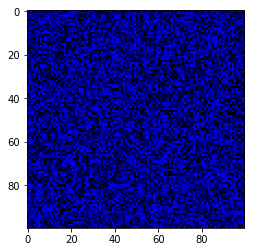

In [3]:
image_mri_1 = np.random.rand(100,100,100,3)+0.001 * 254
image_mri_1[:,:,:,0] = 0
image_mri_1[:,:,:,1] = 0
plt.imshow(image_mri_1[:,1,:,:])
plt.show()

In [4]:
def draw_sphere(array,x0,y0,z0,r, color=[255,255,255]):
    assert x0<array.shape[0]
    assert y0<array.shape[1]
    assert z0<array.shape[2]
    
    for x in range(array.shape[0]):
        for y in range(array.shape[1]):
            for z in range(array.shape[2]):
                eq = (x-x0)*(x-x0) + (y-y0)*(y-y0) + (z-z0)*(z-z0)  
                if(eq<r*r):
                    array[x,y,z,:] = color
    return array

def get_mask(array):
    mask = np.zeros(array.shape[:3])
    indices = np.where(array==[255,255,255])[:3]
    mask[indices] = 1
    return mask

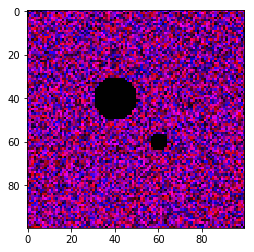

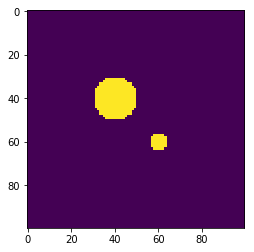

In [5]:
layer = 3
remove_channel = 1
# generate image
image_mri_2 = np.random.rand(100,100,100,3) * 255 +10
image_mri_2[:,:,:,remove_channel] = 0.01 
image_mri_2 = draw_sphere(image_mri_2,40,40,2,10)
image_mri_2 = draw_sphere(image_mri_2,60,60,2,4)
plt.imshow(image_mri_2[:,:,layer,:])
plt.show()
# get mask
m2 = get_mask(image_mri_2)
plt.imshow(m2[:,:,layer])
plt.show()

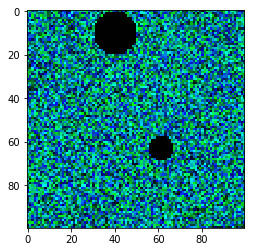

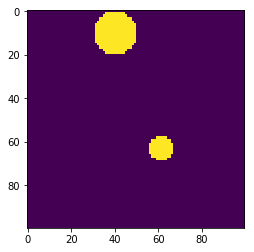

In [6]:
layer = 3
remove_channel = 0 
# generate image
image_mri_3 = np.random.rand(100,100,100,3) * 255 +10
image_mri_3[:,:,:,remove_channel] = 0.01 
image_mri_3 = draw_sphere(image_mri_3,10,40,2,10)
image_mri_3 = draw_sphere(image_mri_3,63,61,7,7)
plt.imshow(image_mri_3[:,:,layer,:])
plt.show()
# get mask
m3 = get_mask(image_mri_3)
plt.imshow(m3[:,:,layer])
plt.show()

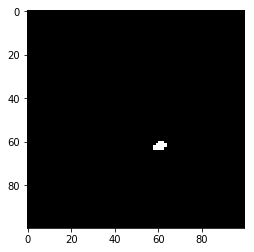

In [7]:
intersection_indices = np.where(image_mri_2==image_mri_3)
intersection_image = np.zeros(image_mri_2.shape)
intersection_image[intersection_indices] = 1
plt.imshow(intersection_image[:,:,1])
plt.show()

In [8]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

def get_clusters_indices(labeled_image, background_label=False):
    
    # Get cluster indices of a 
    labels = np.unique(labeled_image)
    clusters_indices = dict()
    for l in labels:
        if(l==0 and background_label is False): #Don't need background labels
            continue
            
        indices_l = np.where(labeled_image==l)
        clusters_indices[l] = indices_l
        
    return clusters_indices

def get_non_overlapping_indices(clusters_indices_a, clusters_indices_b):
    swapping_indices_a = []
    for ka in clusters_indices_a.keys():
        indices_a = clusters_indices_a[ka]
        list_a = [tuple(x) for x in np.array(indices_a).T]
        intersect = False
        
        for kb in clusters_indices_b.keys():
            if(intersect is False):
                indices_b = clusters_indices_b[kb]
                list_b = [tuple(x) for x in np.array(indices_b).T]

                if(len(set(list_a).intersection(set(list_b)))!=0): #intersection with one cluster
                    intersect = True
        
        if(intersect is False):
            swapping_indices_a.append(indices_a)
        
    return swapping_indices_a


def image_swap(image_a, image_b, mask_a, mask_b, swapping_shape='original'):
    assert image_a.shape == image_b.shape
    assert mask_a.shape == mask_b.shape
    
    # segment blobs in masks
    clustered_tissues_a =  measure.label(mask_a)
    clustered_tissues_b =  measure.label(mask_b)
    
    # Get cluster indices of a 
    clusters_indices_a = get_clusters_indices(clustered_tissues_a)
    clusters_indices_b = get_clusters_indices(clustered_tissues_b)
    
    # Get non-intersecting indices of A with B
    swapping_indices_a = get_non_overlapping_indices(clusters_indices_a, clusters_indices_b)
    swapping_indices_b = get_non_overlapping_indices(clusters_indices_b, clusters_indices_a)
    
    image_swapped_a = image_a.copy()
    image_swapped_b = image_b.copy()
    
    # Perform swap
    for idx in swapping_indices_a:
        image_swapped_a[idx] = image_b[idx]
    
    for idx in swapping_indices_b:
        image_swapped_b[idx] = image_a[idx]
        
    intersection_indices = np.where((mask_a==mask_b) & (mask_a==1))
    intersection_image = np.zeros(mask_a.shape)
    intersection_image[intersection_indices] = 1

    return image_swapped_a, image_swapped_b, intersection_image
                

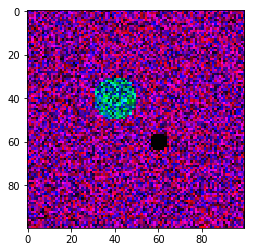

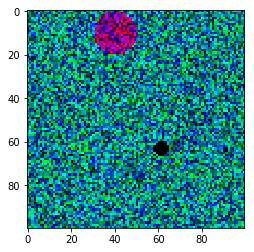

In [9]:
layer = 1

image_a, image_b, intersection = image_swap(image_mri_2,image_mri_3,m2,m3)
plt.imshow(image_a[:,:,layer])
plt.show()
plt.imshow(image_b[:,:,layer])
plt.show()

In [10]:
def get_clusters_indices(labeled_image, background_label=False):
    
    # Get cluster indices of a 
    labels = np.unique(labeled_image)
    clusters_indices = dict()
    for l in labels:
        if(l==0 and background_label is False): #Don't need background labels
            continue
            
        indices_l = np.where(labeled_image==l)
        clusters_indices[l] = indices_l
        
    return clusters_indices

## Swapping regions using shapes (NOT FINISHED)

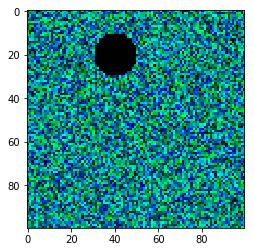

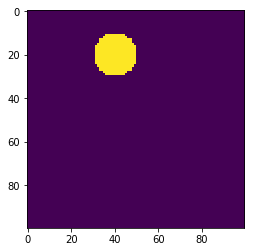

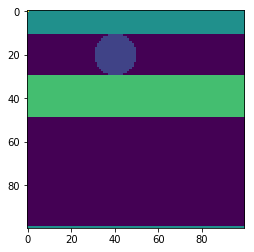

In [11]:
layer = 3
remove_channel = 0 
# generate image
image_mri_3 = np.random.rand(100,100,100,3) * 255 +10
image_mri_3[:,:,:,remove_channel] = 0.01 
image_mri_3 = draw_sphere(image_mri_3,20,40,2,10)
plt.imshow(image_mri_3[:,:,layer,:])
plt.show()
# get mask
m3 = get_mask(image_mri_3)
plt.imshow(m3[:,:,layer])
plt.show()

def draw_shape(mask, shape='cube', margin=2):
    m = mask.copy()
    
    idx = np.where(m==1)
    a = np.min(idx,axis=0)-1
    b = np.max(idx,axis=0)-1
    #m[idx[a,:,:]] = 0.5
    m[a] = 0.5
    m[b] = 0.7
    m[idx] = 0.2
    m[0,0,0] = 1
    return m

plt.imshow(draw_shape(m3)[:,:,0])
plt.show()

## Test swap on ATLAS Data

In [12]:
import os
def plot_patient(path, patient, layer, return_image_and_labels = False):
    path = os.path.join(path,str(patient),"t01")
    nii_file = nb.load(os.path.join(path,'output.nii'))
    img = nii_file.get_data()
    
    lesion_file = str(patient)+"_LesionSmooth_stx.nii"
    nii_file = nb.load(os.path.join(path,lesion_file))
    lesion = nii_file.get_data()
    
    fig = plt.figure(figsize=[15,5])
    plt.subplot(121)
    plt.imshow(img[:,:,layer])
    plt.subplot(122)
    plt.imshow(lesion[:,:,layer])
    fig.suptitle("Patient "+patient+" [{}]".format(layer),fontsize=20)
    plt.show()
    
    if return_image_and_labels:
        return img,lesion
    
def plot_image(img1, img2, lesion, layer):
    fig = plt.figure(figsize=[15,5])
    plt.subplot(131)
    plt.imshow(img1[:,:,layer])
    plt.subplot(132)
    plt.imshow(img2[:,:,layer])
    plt.subplot(133)
    plt.imshow(lesion[:,:,layer])
    fig.suptitle("Swapped images [{}]".format(layer),fontsize=20)
    plt.show()

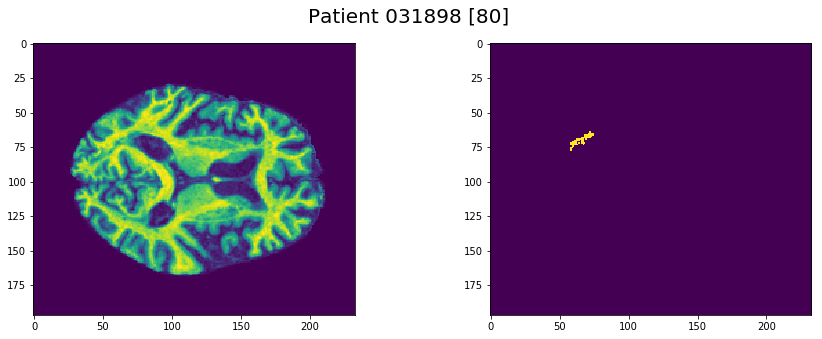

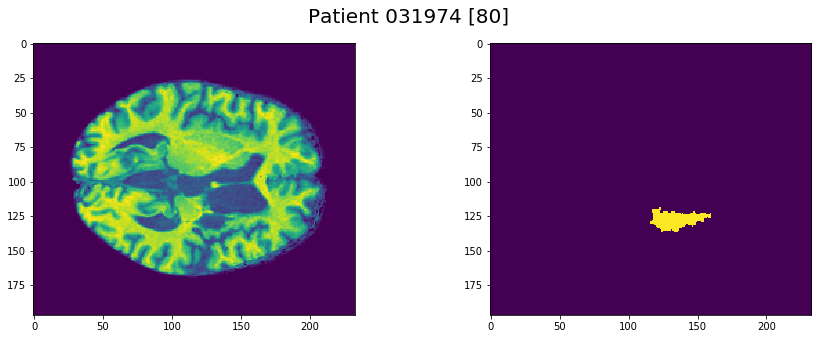

In [16]:
siteA=5
pathA = "/home/simon/Datasets/Stroke_DeepLearning_ATLASdataset/Site"+str(siteA)+"/"
siteB=9
pathB = "/home/simon/Datasets/Stroke_DeepLearning_ATLASdataset/Site"+str(siteB)+"/"
layer = 80

image_a, lesion_a = plot_patient(pathA,"031898",layer, return_image_and_labels=True)
image_b, lesion_b = plot_patient(pathB,"031974",layer, return_image_and_labels=True)

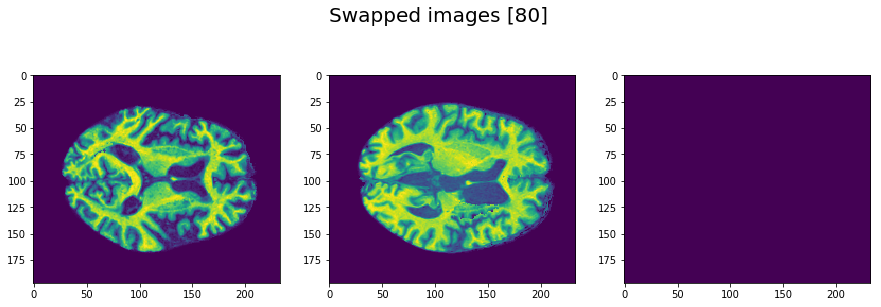

In [17]:
transform_a, transform_b, intersection = image_swap(image_a, image_b, lesion_a, lesion_b)
plot_image(transform_a,transform_b,intersection,80)